In [ ]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Téléchargez les ressources nécessaires pour NLTK
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
!pip install unidecode


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import string
from unidecode import unidecode
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import nltk
from nltk.corpus import stopwords
stopwords_fr = stopwords.words('french')
from nltk.stem import WordNetLemmatizer

from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Bidirectional

from keras.layers import Dense
from keras import regularizers

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer

# Créer un dictionnaire français à partir des mots français contenus dans la liste des mots français du corpus nltk
fr_dict = set(stopwords.words('french'))

from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dropout, Dense, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

In [ ]:
df = pd.read_csv("french_tweets.csv")
print(df.dtypes)
print(df.head())

label     int64
text     object
dtype: object
   label                                               text
0      0  - Awww, c'est un bummer. Tu devrais avoir davi...
1      0  Est contrarié qu'il ne puisse pas mettre à jou...
2      0  J'ai plongé plusieurs fois pour la balle. A ré...
3      0  Tout mon corps a des démangeaisons et comme si...
4      0  Non, il ne se comporte pas du tout. je suis en...


In [ ]:
df_echantillon = df.groupby('label', group_keys=False).apply(lambda x: x.sample(min(len(x), 5000)))

repartition_labels = df_echantillon['label'].value_counts()
print(repartition_labels)

0    5000
1    5000
Name: label, dtype: int64


In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub("&lt;/?.*?&gt;", " &lt;&gt; ", text)
    text = re.sub(r'[@/#]', '', text)
    text = re.sub("(\\d|\\W)+", " ", text)
    text = re.sub(r'_+', '', text)
    text = unidecode(text)
    tokens = nltk.word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    text = ' '.join(tokens)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"
                           u"\U0001F300-\U0001F5FF"
                           u"\U0001F680-\U0001F6FF"
                           u"\U0001F1E0-\U0001F1FF"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


df_echantillon['text']=df_echantillon['text'].apply(clean_text)
df_echantillon['text'] = df_echantillon['text'].apply(remove_emoji)
df_echantillon.head()

,label,text
551282,0,j ai entendu dire que la qualite et la couvert...
78236,0,heureuse fete de mere il me manque ma mere
425948,0,je ne veux meme pa aller au travail aujourd hu...
415198,0,je suis assis et je suis tres froid et bouleve...
218157,0,je sais ce que tu ressens ca va etre bien


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_echantillon['text'])
X = tokenizer.texts_to_sequences(df_echantillon['text'])
X = pad_sequences(X)
y = np.array(df_echantillon['label'])
X = np.reshape(X, (X.shape[0],X.shape[1],1))
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
texts = df_echantillon['text'].tolist()
vocab_size = 1000

embedding_dim = 100

tokenizer = Tokenizer(num_words=vocab_size)

tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)

max_len = 100

X = pad_sequences(sequences, maxlen=max_len)

y = np.array(df_echantillon['label'])

Test de differents nombre de neurones par couche

In [ ]:
inputs_bi = Input(shape=(max_len,))
embedding_layer_bi = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len)(inputs_bi)

x_bi = Bidirectional(LSTM(128, return_sequences=True))(embedding_layer_bi)
x_bi = Dropout(0.2)(x_bi)
x_bi = Bidirectional(LSTM(64))(x_bi)
x_bi = Dropout(0.2)(x_bi)

outputs_bi = Dense(1, activation='sigmoid')(x_bi)

modeleBi = Model(inputs=inputs_bi, outputs=outputs_bi)

modeleBi.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 100)          100000    
                                                                 
 bidirectional (Bidirection  (None, 100, 256)          234496    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 100, 256)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 128)               0     

In [ ]:
learning_rate = 0.001

optimizer = Adam(learning_rate=learning_rate)

modeleBi.compile(loss='binary_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_bi = modeleBi.fit(X_train, y_train, epochs=15, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/15
100/100 [==============================] - 98s 808ms/step - loss: 0.6384 - accuracy: 0.6322 - val_loss: 0.5764 - val_accuracy: 0.6956
Epoch 2/15
100/100 [==============================] - 78s 780ms/step - loss: 0.5257 - accuracy: 0.7436 - val_loss: 0.5587 - val_accuracy: 0.7200
Epoch 3/15
100/100 [==============================] - 82s 813ms/step - loss: 0.4897 - accuracy: 0.7691 - val_loss: 0.5687 - val_accuracy: 0.7200
Epoch 4/15
100/100 [==============================] - 76s 765ms/step - loss: 0.4624 - accuracy: 0.7839 - val_loss: 0.5923 - val_accuracy: 0.7000
Epoch 5/15
100/100 [==============================] - 81s 814ms/step - loss: 0.4391 - accuracy: 0.8006 - val_loss: 0.6034 - val_accuracy: 0.6963
Epoch 6/15
100/100 [==============================] - 76s 761ms/step - loss: 0.4170 - accuracy: 0.8177 - val_loss: 0.6061 - val_accuracy: 0.7025
Epoch 7/15
100/100 [==============================] - 77s 770ms/step - loss: 0.3973 - accuracy: 0.8220 - val_loss: 0.6591 - val_ac

In [ ]:

loss_bi, accuracy_bi = modeleBi.evaluate(X_test, y_test)
print("Test Loss (BiLSTM):", loss_bi)
print("Test Accuracy (BiLSTM):", accuracy_bi)

63/63 [==============================] - 11s 142ms/step - loss: 0.5686 - accuracy: 0.7125
Test Loss (BiLSTM): 0.5686013698577881
Test Accuracy (BiLSTM): 0.7124999761581421


63/63 [==============================] - 12s 157ms/step


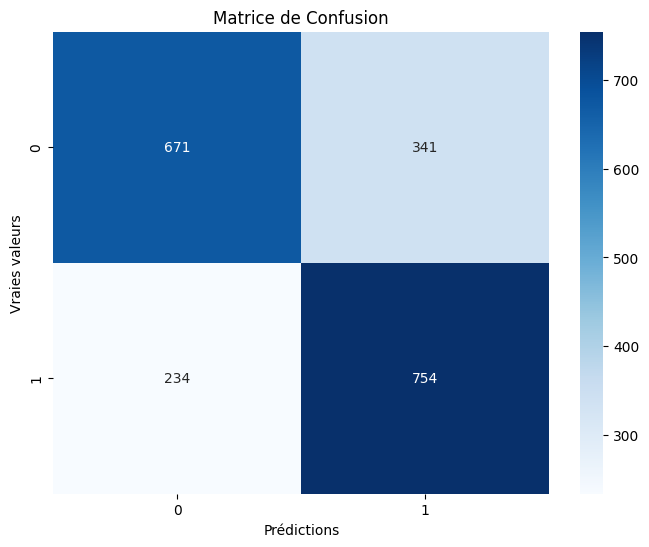

In [ ]:

y_pred = modeleBi.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

conf_matrix = confusion_matrix(y_test, y_pred_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de Confusion')
plt.show()

**Recherche taille batch**

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 100, 100)          100000    
                                                                 
 bidirectional_2 (Bidirecti  (None, 100, 256)          234496    
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 100, 256)          0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 128)               0   

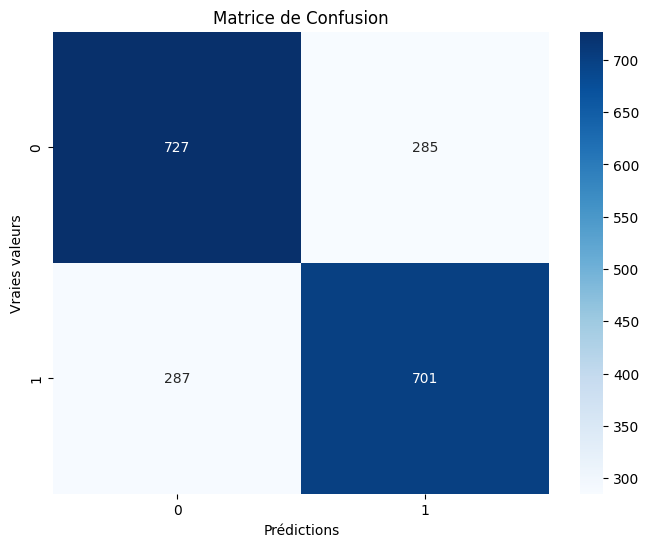

In [ ]:

inputs_bi = Input(shape=(max_len,))

embedding_layer_bi = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len)(inputs_bi)

x_bi = Bidirectional(LSTM(128, return_sequences=True))(embedding_layer_bi)
x_bi = Dropout(0.2)(x_bi)
x_bi = Bidirectional(LSTM(64))(x_bi)
x_bi = Dropout(0.2)(x_bi)

outputs_bi = Dense(1, activation='sigmoid')(x_bi)

modeleBi = Model(inputs=inputs_bi, outputs=outputs_bi)

modeleBi.summary()

learning_rate = 0.001

optimizer = Adam(learning_rate=learning_rate)

modeleBi.compile(loss='binary_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_bi = modeleBi.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

loss_bi, accuracy_bi = modeleBi.evaluate(X_test, y_test)
print("Test Loss (BiLSTM):", loss_bi)
print("Test Accuracy (BiLSTM):", accuracy_bi)

y_pred = modeleBi.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

conf_matrix = confusion_matrix(y_test, y_pred_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de Confusion')
plt.show()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 100, 100)          100000    
                                                                 
 bidirectional_4 (Bidirecti  (None, 100, 256)          234496    
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 100, 256)          0         
                                                                 
 bidirectional_5 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 128)               0   

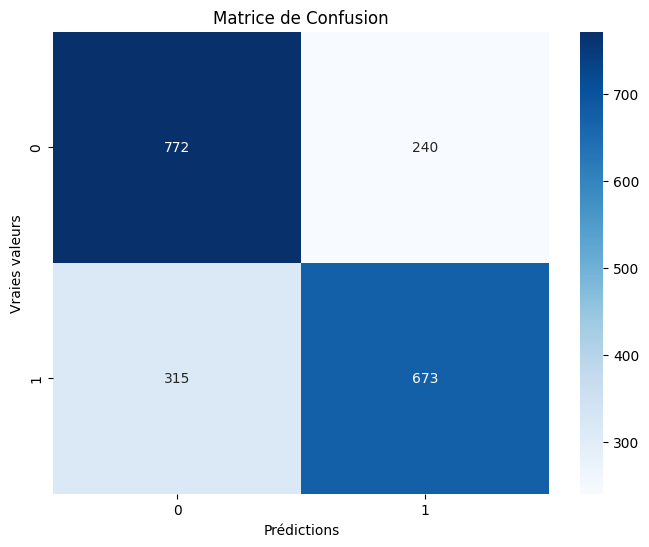

In [ ]:
inputs_bi = Input(shape=(max_len,))
embedding_layer_bi = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len)(inputs_bi)

x_bi = Bidirectional(LSTM(128, return_sequences=True))(embedding_layer_bi)
x_bi = Dropout(0.2)(x_bi)
x_bi = Bidirectional(LSTM(64))(x_bi)
x_bi = Dropout(0.2)(x_bi)

outputs_bi = Dense(1, activation='sigmoid')(x_bi)

modeleBi = Model(inputs=inputs_bi, outputs=outputs_bi)

modeleBi.summary()

learning_rate = 0.001

optimizer = Adam(learning_rate=learning_rate)

modeleBi.compile(loss='binary_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_bi = modeleBi.fit(X_train, y_train, epochs=15, batch_size=16, validation_split=0.2, callbacks=[early_stopping])

loss_bi, accuracy_bi = modeleBi.evaluate(X_test, y_test)
print("Test Loss (BiLSTM):", loss_bi)
print("Test Accuracy (BiLSTM):", accuracy_bi)

y_pred = modeleBi.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

conf_matrix = confusion_matrix(y_test, y_pred_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de Confusion')
plt.show()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 100, 100)          100000    
                                                                 
 bidirectional_6 (Bidirecti  (None, 100, 256)          234496    
 onal)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 100, 256)          0         
                                                                 
 bidirectional_7 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dropout_7 (Dropout)         (None, 128)               0   

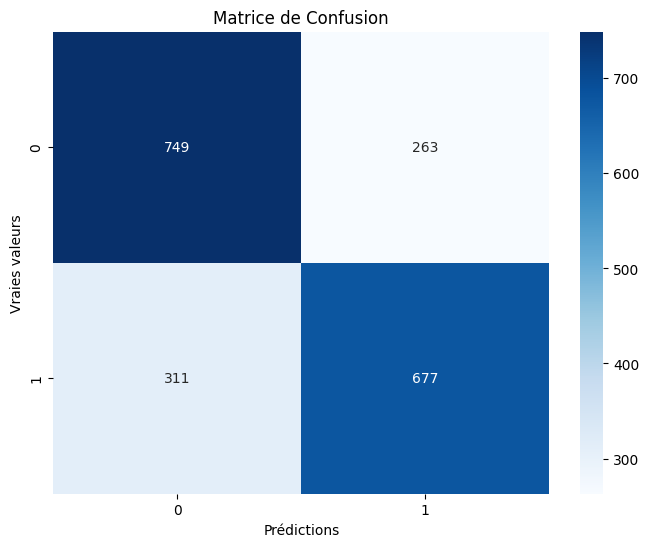

In [ ]:
inputs_bi = Input(shape=(max_len,))
embedding_layer_bi = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len)(inputs_bi)

x_bi = Bidirectional(LSTM(128, return_sequences=True))(embedding_layer_bi)
x_bi = Dropout(0.2)(x_bi)
x_bi = Bidirectional(LSTM(64))(x_bi)
x_bi = Dropout(0.2)(x_bi)

outputs_bi = Dense(1, activation='sigmoid')(x_bi)

modeleBi = Model(inputs=inputs_bi, outputs=outputs_bi)

modeleBi.summary()

learning_rate = 0.001

optimizer = Adam(learning_rate=learning_rate)

modeleBi.compile(loss='binary_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_bi = modeleBi.fit(X_train, y_train, epochs=15, batch_size=128, validation_split=0.2, callbacks=[early_stopping])

loss_bi, accuracy_bi = modeleBi.evaluate(X_test, y_test)
print("Test Loss (BiLSTM):", loss_bi)
print("Test Accuracy (BiLSTM):", accuracy_bi)

y_pred = modeleBi.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

conf_matrix = confusion_matrix(y_test, y_pred_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de Confusion')
plt.show()